## TDI Data Preparation
-----
1. Input File 1 Facebook Followers Data: `temp_datalab_records_social_facebook.csv`     
    - source: Thinknum [https://blog.thedataincubator.com/tag/data-sources/]
2. Input File 2 Firm Codes: `cusip.csv`
3. Input File 3 Firm Codes(2-digit code): `sic_2_digit_codes.csv`               
    - source: https://www.sec.gov/info/edgar/siccodes.htm
-----
1. Output File 1 (cleaned Facebook data): `facebook3.csv`
1. Output File 2 (unique user in the Facebook data): `user_list.csv`
1. Output File 3 (fisrt step match with industry information): `first_match.csv`
1. Output File 4 (final step match with industry information): `final_match.csv`
1. Output File 5 (final step match with industry information (only focused industry)): `facebook4.csv`

## Set up

In [16]:
#! ./workflow.sh

In [25]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='white', font_scale=1)

from datetime import datetime

import csv

import math
from difflib import SequenceMatcher

from collections import Counter

from fuzzywuzzy import fuzz

import sys
del sys.modules['tdi']

import tdi

In [53]:
# input data
file1 = 'temp_datalab_records_social_facebook.csv'
file2 = 'cusip.csv'
file3 = 'sic_2_digit_codes.csv'
# output data
output1 = 'facebook3_2.csv'
output2 = 'user_list.csv'
output3 = 'first_match.csv'
output4 = 'final_match.csv'
output5 = 'facebook4.csv'

### Read Data

In [3]:
facebook = pd.read_csv(file1)

/Users/abbypro/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
facebook.dtypes

dataset_id               int64
time                    object
username                object
checkins                 int64
has_added_app           object
were_here_count          int64
likes                    int64
talking_about_count      int64
facebook_id              int64
date_added              object
date_updated            object
entity_id              float64
cusip                  float64
isin                   float64
dtype: object

In [5]:
# convert string to datatime
facebook['time_2'] = pd.to_datetime(facebook['time'])
facebook['date_updated_2'] = pd.to_datetime(facebook['date_updated'])

In [50]:
facebook['user'] = facebook['username'].str.upper()

In [51]:
useful_cols = ['dataset_id','facebook_id', 'username', 'user',
               'checkins', 'were_here_count', 'likes', 'talking_about_count', 
               'time_2','date_updated_2']

In [55]:
user_list = facebook['user'].value_counts().index.tolist()

In [26]:
user_list_df = pd.DataFrame(user_list)
user_list_df.to_csv(output2, index=False)

### Match Industry Code

In [924]:
match_threshold = 0.3
latest_year = 2010

In [925]:
# dataset of firm names and id
cusip = pd.read_csv(file2)

In [926]:
com_names = cusip['conm'].tolist()

In [927]:
'Total companies with industry information: {:,}'.format(len(com_names))

'Total companies with industry information: 38,089'

In [928]:
stop_words = ('INC',
 'CORPORATION',
 'CORP',
 'LTD',
 'CO',
 'GROUP',
 'ENERGY',
 'INDUSTRIES',
 'HOLDINGS',
 'HOLDING',
 'HLDGS',
 'INDS',
 'ETF',
 'INTL',
 'RESOURCES',
 'FINANCIAL',
 '-CL',
 'SYSTEMS',
 'BANCORP',
 'TECHNOLOGIES',
 'INTERNATIONAL',
 'FD',
 'TR',
 'GLOBAL',
 'CP',
 '-REDH',
 'OIL',
 'TRUST',
 'GOLD',
 'FUND',
 'INCOME',
 'SERVICES',
 'GAS',
 'PLC',
 'US',
 'OF',
 '-OLD',
 'NATIONAL',
 'MSCI',
 'FORMA',
 'INCM',
 'INC-REDH',
 'INC-OLD',
 'PROPERTIES',
 'GENERAL',
 'BANK',
 'POWERSHARES',
 'PARTNERS',
 'TECH',
 'PROSHARES',
 'ENTERPRISES',
 'STORES',
 'SYS',
 'PRODUCTS',
 'FINL',
 'BRANDS',
 'ASSET',
 'REAL',
 'TECHNOLOGY',
 'SOLUTIONS',
 'ACQUISITION',
 'INVESTMENT',
 '-LP',
 '-ADR',
 'GRP',
 'LLC',
 'BANKSHARES',
 '')

In [929]:
com_names_cleaned = []

for n in com_names:
    name = n.split(" ")
    common = set(name).intersection(stop_words)
    n_cleaned = ' '.join([c for c in name if c not in common])
    if n_cleaned == '':
        com_names_cleaned.append((n,n))
    else:
        com_names_cleaned.append((n,n_cleaned))

In [930]:
df_names_cleaned = pd.DataFrame(com_names_cleaned)
df_names_cleaned.columns = ['conm','name_cleaned']

In [931]:
cusip_c = cusip.merge(df_names_cleaned)

In [932]:
cusip_c.drop_duplicates('conm', inplace = True)

In [933]:
df_match = pd.DataFrame()
for idx,u in enumerate(user_list):
    
    good = cusip_c['name_cleaned'].str.contains(u)
    temp = cusip_c[good]
    temp['user'] = u

    df_match = df_match.append(temp, ignore_index = True) 
    
    if idx % 100 == 0:
        print('{:.0f}%'.format(idx/len(user_list)*100))

0%


/Users/abbypro/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


2%
4%
6%
8%
10%
12%
14%
16%
18%
20%
22%
25%
27%
29%
31%
33%
35%
37%
39%
41%
43%
45%
47%
49%
51%
53%
55%
57%
59%
61%
63%
65%
67%
70%
72%
74%
76%
78%
80%
82%
84%
86%
88%
90%
92%
94%
96%
98%


In [934]:
df_match.shape

(11135, 11)

In [935]:
# create a new column 'diff' and get the result of comparison to it
df_match['diff1'] = df_match[['name_cleaned','user']].apply(lambda x: SequenceMatcher(None, x[0].strip(), x[1].strip()).ratio(), axis=1) 

In [936]:
# create a new column 'diff' and get the result of comparison to it
df_match['diff2'] = df_match[['name_cleaned','user']].apply(lambda x: fuzz.token_sort_ratio(x[0].strip(), x[1].strip()), axis=1) 

In [937]:
df_match.head()

,gvkey,conm,tic,cusip,cik,sic,naics,year1,year2,name_cleaned,user,diff1,diff2
0,19881,2U INC,TWOU,90214J101,1459417.0,7370,519130.0,2011,2016,2U,2U,1.000000,100
1,133665,UNIVERSE2U INC,UTOU,914019104,1094089.0,1731,235310.0,1999,2001,UNIVERSE2U,2U,0.333333,33
2,7611,MULTIVOX CORP OF AMERICA,1768B,625469101,68848.0,3651,334310.0,1973,1983,MULTIVOX AMERICA,TIVO,0.400000,40
3,30684,TIVOLI INDUSTRIES INC,TVLI,888711306,924835.0,3640,335122.0,1992,1998,TIVOLI,TIVO,0.800000,80
4,31603,TIVOLI SYSTEMS INC,TIVS.1,888722105,900120.0,7372,511210.0,1990,1994,TIVOLI,TIVO,0.800000,80


In [940]:
df_match.sort_values(['user','diff1'],ascending = [True, False], inplace = True)

In [941]:
df_match.to_csv(output3, index=False)

In [942]:
df_match.columns

Index(['gvkey', 'conm', 'tic', 'cusip', 'cik', 'sic', 'naics', 'year1',
       'year2', 'name_cleaned', 'user', 'diff1', 'diff2'],
      dtype='object')

In [943]:
match_found = df_match['user'].value_counts().index.tolist()
'Number of Users Found Match: {}'.format(len(match_found))

'Number of Users Found Match: 611'

In [944]:
match_perfect = df_match[df_match.diff1 == 1]['user'].value_counts().index.tolist()
'Number of Users Found Pefect Match: {}'.format(len(match_perfect))

'Number of Users Found Pefect Match: 427'

In [945]:
'Non-perfect Matches: {}'.format(len(match_found) - len(match_perfect))

'Non-perfect Matches: 184'

------

In [946]:
temp = df_match[df_match.diff1 == 1]['user'].value_counts()

In [947]:
perfect_multi = set(temp[temp > 1].index.tolist())

In [948]:
perfect_match1 = temp[temp == 1].index.tolist()

In [949]:
part1 = df_match[df_match.user.isin(perfect_match1)&(df_match.diff1 == 1)].drop_duplicates('user')
part1['match_status'] = 'perfect match'

In [950]:
perfect_match1 = part1.user.tolist()

In [951]:
good = (df_match.user.isin(perfect_multi))&(df_match.year2 > latest_year)&(df_match.diff1 == 1)
temp = df_match[good].groupby('user').size()

In [952]:
perfect_match2 = temp[temp == 1].index.tolist()

In [953]:
part2 = df_match[df_match.user.isin(perfect_match2)&
                 (df_match.year2 > latest_year)&(df_match.diff1 == 1)].sort_values(['user','diff1','year2'], 
                                                             ascending = False).drop_duplicates('user')
part2['match_status'] = 'perfect match'

In [954]:
perfect_match2 = part2.user.tolist()

In [955]:
perfect_match = set(perfect_match1 + perfect_match2)

In [956]:
less_perfect_match = set(perfect_multi) - set(perfect_match2)

In [957]:
part3 = df_match[df_match.user.isin(less_perfect_match)&
                 (df_match.year2 > latest_year)&(df_match.diff1 == 1)].sort_values(['user','diff1','year2'], 
                                                             ascending = False).drop_duplicates('user')
part3['match_status'] = 'less than perfect match'

In [958]:
less_perfect_match = set(part3.user.tolist())

-------

In [959]:
df_match_further = df_match[(df_match.diff1 < 1) 
                            & (df_match.diff1 > match_threshold) & (df_match.year2 > latest_year)]

In [960]:
df_match_further['check'] = df_match_further[['name_cleaned','user']].apply(lambda x: x[1] in x[0].split(' '), axis = 1)

/Users/abbypro/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [961]:
df_match_further['check'].value_counts()

False    1267
True      500
Name: check, dtype: int64

In [962]:
ok_match0 = df_match_further[df_match_further['check']]['user'].value_counts().index.tolist()

In [963]:
ok_match  = set(ok_match0) - less_perfect_match - perfect_match

In [964]:
part4 = df_match[df_match.user.isin(ok_match)&
                 (df_match.diff1 < 1) & (df_match.diff1 > match_threshold) 
                 & (df_match.year2 > latest_year)].sort_values(['user','diff1','year2'], 
                                                             ascending = False).drop_duplicates('user')
part4['match_status'] = 'ok match'

------

In [965]:
bad_match = set(match_found) - ok_match - less_perfect_match - perfect_match

In [966]:
part5 = df_match[df_match.user.isin(bad_match)&
                 (df_match.year2 > latest_year)].sort_values(['user','diff1','year2'], 
                                                             ascending = False).drop_duplicates('user')
part5['match_status'] = 'bad match'

In [967]:
bad_match = set(part5.user.tolist())

-----

In [968]:
print('bad match: {0}\nok match: {1}\nless perfect match: {2}\nperfect match: {3}\ntotal match: {4}'.format(len(bad_match),
                                                                                                      len(ok_match),
                                                                                                      len(less_perfect_match),
                                                                                                      len(perfect_match),
                         len(bad_match)+len(ok_match)+len(less_perfect_match)+len(perfect_match)))

bad match: 46
ok match: 107
less perfect match: 21
perfect match: 397
total match: 571


In [969]:
'No match: {:,}'.format(len(set(user_list)) - (len(bad_match)+len(ok_match)+len(less_perfect_match)+len(perfect_match)))

'No match: 4,320'

In [970]:
df_match_final = pd.concat([part1,part2,part3,part4,part5])

In [971]:
df_match_final.match_status.value_counts()

perfect match              397
ok match                   107
bad match                   46
less than perfect match     21
Name: match_status, dtype: int64

In [972]:
df_match_final.shape

(571, 14)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12675b278>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126770a90>]], dtype=object)

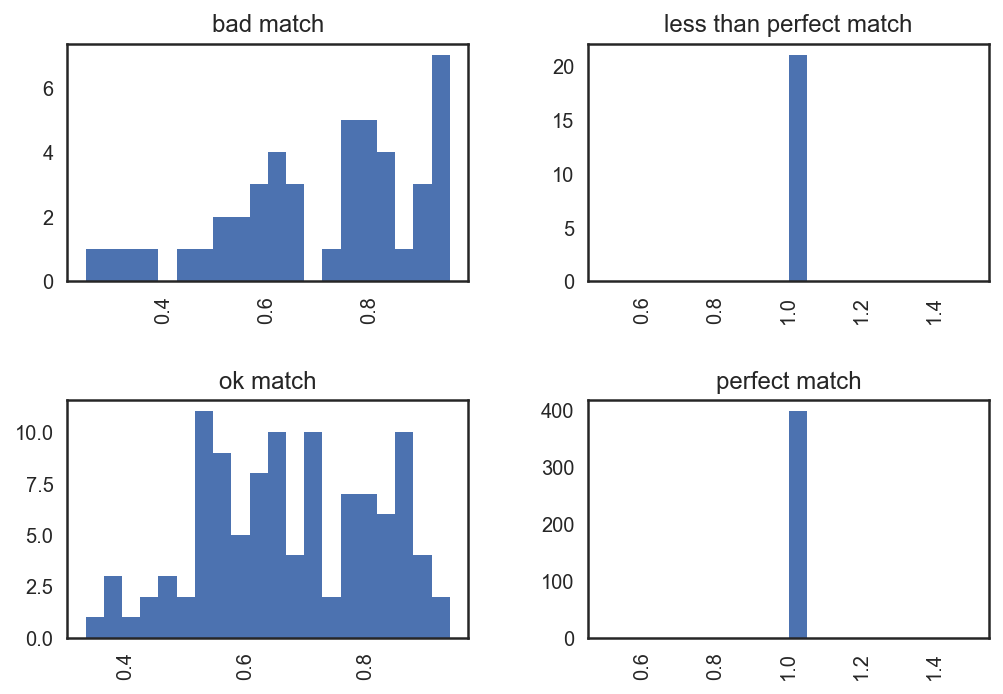

In [973]:
df_match_final['diff1'].hist(by=df_match_final['match_status'], bins = 20)

In [975]:
df_match_final.to_csv(output4, index = False)

-----

### 2-digits Industry Code

In [976]:
sic_2 = pd.read_csv(file3)

In [977]:
sic_2.columns = ['sic_2digit','industry_short']

In [978]:
facebook = facebook[useful_cols].merge(df_match_final, how = 'left')

In [979]:
facebook['sic_2digit'] = facebook['sic'] // 100
facebook['sic_2digit'] = facebook['sic_2digit'].fillna(0)
facebook['sic_2digit'] = facebook['sic_2digit'].astype('int')
facebook3 = facebook.merge(sic_2, how = 'left')

In [980]:
facebook3['industry_short'] = facebook3['industry_short'].fillna('Not Available')

In [983]:
facebook.shape

(3621391, 24)

In [982]:
facebook3.dtypes

dataset_id                      int64
facebook_id                     int64
username                       object
user                           object
checkins                        int64
were_here_count                 int64
likes                           int64
talking_about_count             int64
time_2                 datetime64[ns]
date_updated_2         datetime64[ns]
gvkey                         float64
conm                           object
tic                            object
cusip                          object
cik                           float64
sic                           float64
naics                         float64
year1                         float64
year2                         float64
name_cleaned                   object
diff1                         float64
diff2                         float64
match_status                   object
sic_2digit                      int64
industry_short                 object
dtype: object

------

### Time Period

In [1002]:
#tdi.period.values()

dict_values(['M', 'D', 'Q', 'A', 'W'])

In [30]:
facebook3 = tdi.get_time_period(facebook3, 'A')

In [32]:
facebook3 = tdi.get_time_period(facebook3, 'W')

In [33]:
facebook3 = tdi.get_time_period(facebook3, 'Q')

In [34]:
facebook3 = tdi.get_time_period(facebook3, 'D')

In [35]:
facebook3 = tdi.get_time_period(facebook3, 'M')

In [37]:
#facebook3.dtypes

In [4]:
#facebook3 = pd.read_csv('facebook3.csv')
#facebook3['time_2'] = pd.to_datetime(facebook3['time_2'])
#facebook3['date_updated_2'] = pd.to_datetime(facebook3['date_updated_2'])

-----

## Virtual and Physical Company

### Define virtual firm as no were-here-count and checkins records

In [49]:
col = 'were_here_count'

temp = facebook3.groupby('user')[col].agg({'mean'})
good = temp['mean'] == 0
were_here_none = set(temp[good].index.tolist())

col = 'checkins'

temp = facebook3.groupby('user')[col].agg({'mean'})
good = temp['mean'] == 0
checkins_none = set(temp[good].index.tolist())

virtual = were_here_none.intersection(checkins_none)

facebook3['virtual'] = np.where(facebook3.user.isin(virtual),1,0)

facebook3['virtual'].value_counts()

facebook3['virtual_c'] = np.where(facebook3.virtual == 1,'Virtual','Physical')

facebook3['virtual_c'].value_counts()

Physical    2463731
Virtual     1157660
Name: virtual_c, dtype: int64

### Write to csv

In [50]:
facebook3.to_csv(output1,index=False)

In [986]:
del facebook3

In [51]:
good = facebook3['industry_short'].isin(tdi.focus_industry)
facebook4 = facebook3[good]

In [54]:
facebook4.to_csv(output5,index=False)